<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Qtensor-vs-other-simulators:-speed" data-toc-modified-id="Qtensor-vs-other-simulators:-speed-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Qtensor vs other simulators: speed</a></span><ul class="toc-item"><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Read-data" data-toc-modified-id="Read-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Read data</a></span></li><li><span><a href="#Plot-comparisons" data-toc-modified-id="Plot-comparisons-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plot comparisons</a></span></li><li><span><a href="#CLI" data-toc-modified-id="CLI-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>CLI</a></span></li></ul></li></ul></div>

# Qtensor vs other simulators: speed

The functions from this notebook are exported and invoken on a remote server.

The data that is generated is transferred back to local machine and plotted here as well

## Generate data

In [1]:
#export
import numpy as np
import qtensor
import quimb
import sys
import pyrofiler.c as profile
#sys.path.pop(2)

from qtensor.tests.qiskit_qaoa_energy import simulate_qiskit_amps
from qtensor.tests.qaoa_quimb import simulate_one_parallel as simulate_quimb_energy
from qtensor.tests.acqdp_qaoa import single_qaoa_query as simulate_acqdp_energy
import matplotlib.pyplot as plt
import time

from cartesian_explorer import Explorer, caches, parallels

/home/danlkv/.local/bin/lib/python3.8/site-packages/numba-0.52.0rc2-py3.8-linux-x86_64.egg/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10000. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#export
cache = caches.JobLibCache('../../caex_cache/skylake_speed_comparison')
PAR = True
if PAR:
    parallel = parallels.Ray(processes=55)
    ex = Explorer(cache=cache, parallel=parallel)
else:
    ex = Explorer(cache=cache)

2021-03-13 18:02:57,758	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


In [4]:
#export    
@ex.provider
def graph(N, d=3, graph_type='random', seed=10):
    return qtensor.toolbox.random_graph(nodes=N, type=graph_type, degree=d, seed=seed)

In [5]:
#export
@ex.provider
def simulator(sim, qtn_backend='einsum'):
    simulators = qtensor.tools.benchmarking.simulators
    return {
        'qtensor': simulators.QtensorSimulator(backend=qtn_backend),
        'qtensor_merged': simulators.MergedQtensorSimulator(backend=qtn_backend),
        'qtensor_merged_mkl': simulators.MergedQtensorSimulator(backend='mkl'),
        'qtensor_merged_tr': simulators.MergedQtensorSimulator(backend='tr_einsum'),
        'quimb': simulators.QuimbSimulator(),
        'quimb_Dsimp': simulators.QuimbSimulator(simplify_sequence='D'),
        'acqdp': simulators.AcqdpSimulator(),
        'qiskit': simulators.QiskitSimulator()
    }[sim]

In [6]:
@ex.add_function(provides=('opts', 'energy_flops', 'energy_opt_time', 'energy_mem_est', 'energy_tws')
                 , requires=('graph', 'p', 'simulator')
                )
def energy_cost(graph, p,
                simulator,
                sim='qtensor',
                qtn_ordering_algo='greedy',
                qmb_max_repeats=10,
               ):
    kwargs = {}
    if 'qtensor' in sim:
        kwargs['ordering_algo'] = qtn_ordering_algo
    elif 'quimb' in sim:
        kwargs['max_repeats'] = qmb_max_repeats
    try:
        opts, ests, time = simulator.optimize_qaoa_energy(graph, p, **kwargs)
    except Exception as e:
        print('error', e)
        return None, None, None, None, None
    flops = [est.flops for est in ests]
    mems = [est.mems for est in ests]
    tws = [est.width for est in ests]
    print(flops)
    return opts, sum(flops), time, max(mems), tws
        

In [7]:
@ex.add_function(provides=('energy_time', 'energy_memory')
                 , requires=('graph', 'p', 'simulator', 'opts')
                )
def energy_time(graph, p, simulator, opts,
                sim='qtensor',
               ):
    kwargs = {}
        
    try:
        res, time, memory = simulator.simulate_qaoa_energy(graph, p, opts, **kwargs)
    except Exception as e:
        print('error', e)
        return None, None
    return time, memory

In [8]:
@ex.provider
def energy_max_tw(energy_tws):
    if energy_tws is None:
        return None
    return np.nanmax(energy_tws)

In [9]:
_time = ex.get_variable('energy_time', sim='qiskit', N=10, p=2)
_mem = ex.get_variable('energy_memory', sim='qiskit', N=10, p=2)
print(_time, _mem)

0.32183074951171875 3411968


In [10]:
_time = ex.get_variable('energy_time', sim='qtensor', N=10, p=2)
_mem = ex.get_variable('energy_memory', sim='qtensor', N=10, p=2)
print(_time, _mem)

0.16697263717651367 335872


In [21]:
_time = ex.get_variable('energy_time', sim='acqdp', N=10, p=2)
_mem = ex.get_variable('energy_memory', sim='acqdp', N=10, p=2)
print(_time, _mem)

Preprocessing for energy query...



Preprocessing time for queries: 1.0740618705749512
[Decimal('3592'), Decimal('5680'), Decimal('3812'), Decimal('5744'), Decimal('6128'), Decimal('9000'), Decimal('9352'), Decimal('2980'), Decimal('4096'), Decimal('2404'), Decimal('5928'), Decimal('5136'), Decimal('3080'), Decimal('3736'), Decimal('1948')]



E([0.6609951259027789, -0.07052240338931197, -1.4566024247580716, 1.316253774225727]) = (0.4186488449879163+1.8984318815996733e-17j)



E([1.4704204914312997, 0.8598184003222535, -0.20795954297157124, -1.1122043101115286]) = (2.4971648710269005-1.0328927302658507e-16j)
0.041655778884887695 0


In [ ]:
_time, _mem = ex.get_variables(('energy_time', 'energy_memory'), sim='quimb', N=10, p=2, seed=10)
_tw = ex.get_variable('energy_tws', sim='quimb', N=10, p=2, seed=10)
print(_time, _mem, _tw)

In [ ]:
_time, _mem = ex.get_variables(('energy_time', 'energy_memory'), sim='quimb_Dsimp', N=10, p=2, seed=10)
_tw = ex.get_variable('energy_tws', sim='quimb_Dsimp', N=10, p=2, seed=10)
print(_time, _mem, _tw)

## Generate data

In [10]:
import xarray

In [11]:
#export
def gen_time_data(Ns, ps, **kwargs):
    xar = ex.get_variables_xarray(
        ('energy_flops', 'energy_mem_est', 'energy_opt_time', 'energy_tws', 'energy_max_tw',
         'energy_time', 'energy_memory'),
        p=ps,
        N=Ns,
        **kwargs,
    )
    return xar

In [12]:
Ns = 2*(.5*np.pi**(np.arange(0, 14)/2)).astype(np.int) + 10
Ns = Ns[2:12]

ps = [3, 4, 5] 
seeds = [10, 12, 13, 14]
n_repeats = 20

In [15]:
xar = gen_time_data(Ns, ps, n_processes=[1],
                    sim=['acqdp', 'quimb', 'qtensor', 'qtensor_merged_tr'],
                    qtn_ordering_algo=[f'rgreedy_0.02_{n_repeats}'],
                    qmb_max_repeats=[n_repeats],
                    qiskit_method=['matrix_product_state'],
                    seed=seeds
                   )
xar

RayTaskError(RayOutOfMemoryError): [36mray::apply_kwargs()[39m (pid=16814, ip=10.17.6.144)
  File "python/ray/_raylet.pyx", line 444, in ray._raylet.execute_task
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/ray/memory_monitor.py", line 138, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node skylake07 is used (365.24 / 376.09 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
16846	138.5GiB	ray::apply_kwargs()
16822	84.83GiB	ray::apply_kwargs()
16813	29.25GiB	ray::apply_kwargs()
16860	22.57GiB	ray::apply_kwargs()
16796	20.17GiB	ray::apply_kwargs()
16801	19.78GiB	ray::apply_kwargs()
16863	5.06GiB	ray::apply_kwargs()
16805	2.94GiB	ray::apply_kwargs()
16831	2.93GiB	ray::apply_kwargs()
16812	2.86GiB	ray::apply_kwargs()

In addition, up to 0.0 GiB of shared memory is currently being used by the Ray object store. You can set the object store size with the `object_store_memory` parameter when starting Ray.
---
--- Tip: Use the `ray memory` command to list active objects in the cluster.
---

2021-03-13 06:56:46,895	WARNING worker.py:1091 -- A worker died or was killed while executing task e3f613fc4b91d1adffffffff01000000.


## Read data

In [ ]:
xar = xarray.load_dataarray('../../../second_try.nc')

## Retreive data from cache

In [13]:
data = ex.map_variables_no_call(
    ('energy_flops', 'energy_mem_est', 'energy_opt_time', 'energy_tws', 'energy_max_tw',
     'energy_time', 'energy_memory'),
    p=ps,
    N=Ns,
    n_processes=[1],
    sim=['qiskit', 'acqdp', 'quimb', 'qtensor', 'qtensor_merged_tr'],
    qtn_ordering_algo=[f'rgreedy_0.02_{n_repeats}'],
    qmb_max_repeats=[n_repeats],
    qiskit_method=['matrix_product_state'],
    seed=seeds

)

/home/danlkv/.local/bin/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [20]:
dims = dict(
    varname=['energy_flops', 'energy_mem_est', 'energy_opt_time', 'energy_tws','energy_max_tw',
     'energy_time', 'energy_memory'],
    p=ps,
    N=Ns,
    n_processes=[1],
    sim=['qiskit', 'acqdp', 'quimb', 'qtensor', 'qtensor_merged_tr'],
    #qtn_ordering_algo=['rgreedy_0.02_100'],
    #qmb_max_repeats=[100],
    qiskit_method=['matrix_product_state'],
    seed=seeds
)
_dimcount = len(data.shape)
_dimnames = list(dims.keys())
dimvals = {k:dims[k] for k in _dimnames if len(dims[k])>1}

xar = xarray.DataArray(data, dims=list(dimvals.keys()), coords=dimvals)

In [15]:
#xar.to_netcdf('../../../data/speed_comparison.nc')

In [21]:
def plot_xarray(ex, xar, **kwargs):
    dims = {k:xar.coords[k].data for k in xar.dims}
    kwargs = {**kwargs, **dims}
    def safe_sel(*args, **kwargs):
        try:
            return xar.sel(*args, **kwargs).item()
        except Exception:
            return None
    print('kw', kwargs)
    fig = ex.plot(safe_sel, **kwargs)
    return fig

In [22]:
def data_lists_mean(line_data):
    """[
    [
    [[0, 1, 2], None ], [None, None]
    ]
    to [
    [1, None], [None, None]
    ]
    """
    for i, pt in enumerate(line_data):
        line_data[i] = [np.mean(x) if hasattr(x, '__iter__') else x for x in pt]
    return line_data
    
def plot_with_band(x, line_data, **kwargs):
    # for tws
    line_data = data_lists_mean(line_data)
    
    line_data = line_data.astype(np.float64)
    maxs = np.max(line_data, axis=-1)
    mins = np.min(line_data, axis=-1)
    std = np.nanstd(line_data, axis=-1)
    mean = np.nanmean(line_data, axis=-1)
    relstd = (mean-std)/mean
    
    plt.plot(x, mean, '.-', **kwargs)
    fill_kwargs = dict(
        alpha=0.05, color=kwargs.get('color')
    )
    plt.fill_between(x, mean + std, mean - std, **fill_kwargs)
    

kw {'plot_func': <function plot_with_band at 0x7ff34b3bcf70>, 'distribution_var': 'seed', 'varname': array(['energy_flops', 'energy_time', 'energy_mem_est', 'energy_memory',
       'energy_opt_time', 'energy_tws'], dtype='<U15'), 'sim': array(['qtensor', 'qtensor_merged_tr', 'acqdp', 'quimb'], dtype='<U17'), 'N': array([ 12,  14,  18,  26,  40,  64, 106, 182, 316, 552]), 'seed': array([10, 12, 13, 14])}


/home/danlkv/.local/bin/lib/python3.8/site-packages/cartesian_explorer/ExplorerBasic.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  result = np.array(result_lin).reshape(result_shape)
/home/danlkv/.local/bin/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-22-61007eb23e6e>:22: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(line_data, axis=-1)
/home/danlkv/.local/bin/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-22-61007eb23e6e>:22: RuntimeWarning: Mean of empty slice
  mean = n

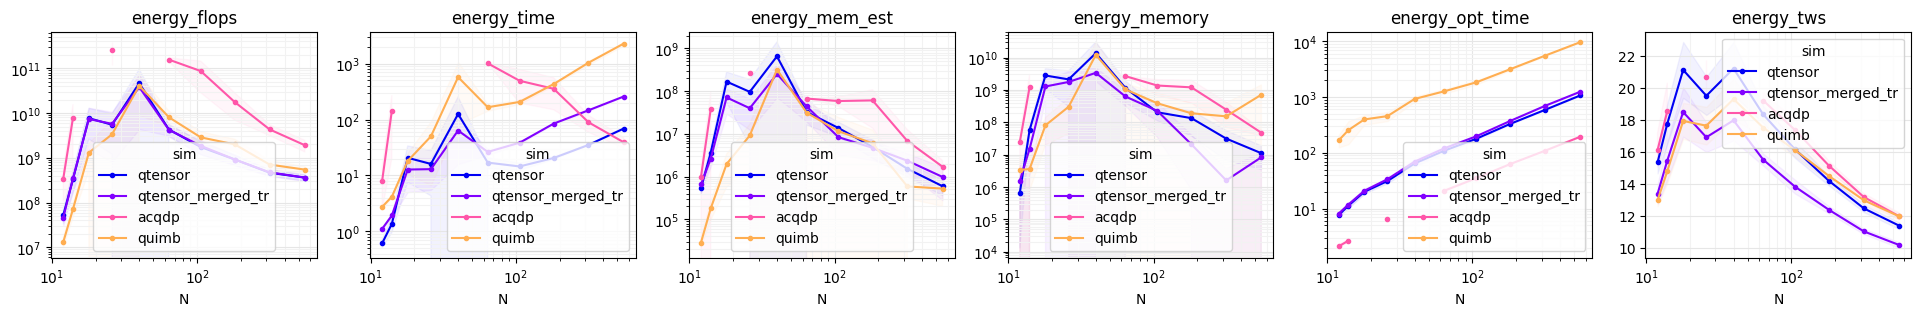

In [26]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N', 'seed')

p = 4
fig = plot_xarray(ex, xar_tr.sel(
    varname=['energy_flops','energy_time',
             'energy_mem_est', 'energy_memory', 'energy_opt_time', 'energy_tws']#,'energy_max_tw']
    #varname=['energy_tws' ]
   , sim=['qtensor', 'qtensor_merged_tr', 'acqdp', 'quimb' ]
   #, sim=['qtensor', 'qtensor_merged', 'acqdp', 'quimb', 'quimb_Dsimp']
    , p=p
), 
            plot_func=plot_with_band,
            distribution_var='seed',
           )

for ax in fig.axes[:5]:
    ax.set_yscale('log')
for ax in fig.axes:
    ax.set_xscale('log')
    
plt.savefig(f'../../../data/figures/speed_comparison_p{p}.pdf')

In [ ]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N', 'seed')

fig = plot_xarray(ex, xar_tr.sel(
    varname=['energy_time', 'energy_memory']
    #varname=['energy_tws' ]
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=5
), 
            plot_func=plot_with_band,
            distribution_var='seed',
           )

for ax in fig.axes[:2]:
    ax.set_yscale('log')

## Performance debugging
### Look at contraction backends

In [14]:
_time = ex.get_variable('energy_time', sim='qtensor_merged', N=20, p=4, seed=13,
                        qtn_ordering_algo='rgreedy_0.02_10', qtn_backend='mkl')
_time

20.676586151123047

In [14]:
p = 5
Ns = 2*(.5*np.pi**(np.arange(0, 14)/2)).astype(np.int) + 10
Ns = Ns[3:6]

fig = ex.plot_variables(('energy_time')
                        , distribution_var='seed'
                        , qtn_backend=['einsum', 'tr_einsum', 'mkl']
                        , sim=['qtensor_merged', 'qtensor', 'quimb']
                        , qtn_ordering_algo=['rgreedy_0.02_10']
                        , qmb_max_repeats=[10]
                        , N=Ns
                        , seed=[10, 11]
                        , p=[p]
)


2021-03-06 01:51:21,604	WARNING worker.py:1091 -- A worker died or was killed while executing task 5aedc3445b289eb5ffffffff01000000.
2021-03-06 01:51:47,507	WARNING worker.py:1091 -- A worker died or was killed while executing task d9a5dd8231409648ffffffff01000000.
2021-03-06 01:51:53,281	WARNING worker.py:1091 -- A worker died or was killed while executing task d623130793ad3e6cffffffff01000000.
2021-03-06 01:51:59,819	WARNING worker.py:1091 -- A worker died or was killed while executing task 5aedc3445b289eb5ffffffff01000000.
2021-03-06 01:52:30,816	WARNING worker.py:1091 -- A worker died or was killed while executing task 2be37c70876ab21affffffff01000000.
2021-03-06 01:52:40,454	WARNING worker.py:1091 -- A worker died or was killed while executing task 5aedc3445b289eb5ffffffff01000000.
2021-03-06 01:52:58,726	WARNING worker.py:1091 -- A worker died or was killed while executing task cc7c51db29a63707ffffffff01000000.
2021-03-06 01:53:14,095	WARNING worker.py:1091 -- A worker died or wa

WorkerCrashedError: The worker died unexpectedly while executing this task.

2021-03-06 01:53:41,115	WARNING worker.py:1091 -- A worker died or was killed while executing task a18dbc46b666c265ffffffff01000000.
2021-03-06 01:53:55,252	ERROR worker.py:1037 -- Possible unhandled error from worker: ray::apply_kwargs() (pid=53311, ip=10.17.6.144)
  File "python/ray/_raylet.pyx", line 444, in ray._raylet.execute_task
  File "/home/danlkv/.local/bin/lib/python3.8/site-packages/ray/memory_monitor.py", line 138, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node skylake07 is used (357.47 / 376.09 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
53337	81.01GiB	ray::apply_kwargs()
53279	74.19GiB	ray::apply_kwargs()
53257	57.88GiB	ray::apply_kwargs()
53331	46.86GiB	ray::apply_kwargs()
53267	37.58GiB	ray::apply_kwargs()
53342	21.65GiB	ray::apply_kwargs()
53307	8.8GiB	ray::apply_kwargs()
53329	2.99GiB	ray::apply_kwargs()
53271	1.9GiB	ray::apply_kwargs()
53284	1.56GiB	ray::apply_kwargs()

In 

### Look at large circuits

In [14]:
Ns

array([ 10,  12,  14,  18,  26,  40,  64, 106, 182, 316])

In [17]:
_time = ex.get_variable('energy_time', sim='qtensor_merged',
                        qtn_backend='tr_einsum',
                        N=64, p=4, seed=10, qmb_max_repeats=25,
                        qtn_ordering_algo='rgreedy_0.02_25')
print(_time)

KeyboardInterrupt: 

In [9]:
#sim = qtensor.tools.benchmarking.simulators.MergedQtensorSimulator(backend='tr_einsum')
sim = qtensor.tools.benchmarking.simulators.AcqdpSimulator(
    ordering_algo='khp', order_finder_params=dict(num_iters=10, num_threads=1))
p = 5
G = graph(20, seed=14)
opts, ests, time = sim.optimize_qaoa_energy(G, p=p)

Preprocessing for energy query...


(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=280283025, Wed Mar 10 06:59:42 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 9.358542284935750e+00 1.0e+00 2.00e-01  2e-01  2e-01 0:08.4
    2     14 8.937479050512549e+00 1.3e+00 2.11e-01  2e-01  3e-01 0:16.1
    3     21 8.863058257304715e+00 1.7e+00 2.22e-01  2e-01  3e-01 0:23.8
    4     28 8.932238861493296e+00 1.6e+00 2.21e-01  2e-01  3e-01 0:31.4
    5     35 9.005886547428338e+00 1.8e+00 2.30e-01  2e-01  3e-01 0:38.7
    6     42 8.843962109076978e+00 1.8e+00 2.21e-01  2e-01  2e-01 0:45.6
    7     49 9.019821852401249e+00 1.4e+00 1.79e-01  1e-01  2e-01 0:52.7
    8     56 8.871325620825399e+00 1.9e+00 1.91e-01  1e-01  2e-01 0:59.8
   10     70 8.903522281300448e+00 2.2e+00 1.29e-01  6e-02  1e-01 1:14.2
(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=1534959500, Wed Mar 10 07:00:57 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7

KeyboardInterrupt: 

In [8]:
print([e.width for e in ests])

[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]


In [17]:
print([e.width for e in ests])

[28, 27, 24, 25, 24, 25, 26, 29, 29, 28, 29, 26, 24, 30, 28, 25, 26, 26, 27, 26, 28, 29, 28, 30, 28, 27, 30, 26, 25, 23]


In [18]:
print(opts[0])

[i_0, i_1, i_2, i_3, i_4, i_5, i_6, i_7, i_8, i_9, i_10, i_11, i_12, i_13, i_14, i_15, i_16, i_17, i_18, i_19, o_0, o_1, o_2, o_3, o_4, o_5, o_6, o_7, o_8, o_9, o_10, o_11, o_12, o_13, o_14, o_15, o_16, o_17, o_18, o_19, v_20, v_21, v_22, v_23, v_24, v_25, v_26, v_27, v_28, v_29, v_30, v_31, v_32, v_33, v_34, v_35, v_36, v_37, v_38, v_39, v_176, v_177, v_178, v_179, v_180, v_181, v_182, v_183, v_184, v_185, v_186, v_187, v_188, v_189, v_190, v_191, v_192, v_193, v_194, v_195, v_116, v_117, v_40, v_43, v_45, v_48, v_49, v_55, v_83, v_91, v_163, v_162, v_94, v_97, v_102, v_104, v_105, v_107, v_112, v_113, v_114, v_115, v_156, v_157, v_160, v_165, v_167, v_175, v_61, v_62, v_66, v_74, v_77, v_80, v_87, v_90, v_143, v_96, v_99, v_149, v_126, v_124, v_129, v_132, v_137, v_140, v_151, v_154, v_44, v_51, v_58, v_101, v_168, v_56, v_141, v_144, v_93, v_110, v_172, v_173, v_41, v_68, v_128, v_119, v_146, v_150, v_54, v_63, v_65, v_89, v_135, v_158, v_82, v_103, v_166, v_76, v_71, v_108, v_120, 

In [32]:
sim.simulate_qaoa_energy(G, p=p, opt=opts)

specific indices set() intersection {v_80}
specific indices set() intersection {v_81}
specific indices set() intersection {v_82}
specific indices set() intersection {v_82}
specific indices set() intersection {v_82}
specific indices set() intersection {v_83}
specific indices set() intersection {v_83}
specific indices set() intersection {v_83}
specific indices set() intersection {v_84}
specific indices set() intersection {v_84}
specific indices set() intersection {v_84}
specific indices set() intersection {v_85}
specific indices set() intersection {v_85}
specific indices set() intersection {v_85}
specific indices set() intersection {v_86}
specific indices set() intersection {v_86}
specific indices set() intersection {v_86}
specific indices set() intersection {v_87}
specific indices set() intersection {v_87}
specific indices set() intersection {v_87}
specific indices set() intersection {v_88}
specific indices set() intersection {v_88}
specific indices set() intersection {v_89}
specific in

specific indices set() intersection {v_174}
specific indices {v_213} intersection {v_174, v_213}
specific indices set() intersection set()
specific indices set() intersection {v_176, v_193, v_178, v_179}
specific indices set() intersection {v_179}
specific indices set() intersection set()
specific indices set() intersection set()
specific indices set() intersection set()
specific indices set() intersection {v_188}
specific indices set() intersection {v_185}
specific indices set() intersection {v_188}
specific indices set() intersection {v_187, v_190}
specific indices set() intersection set()
specific indices set() intersection set()
specific indices set() intersection {v_203}
specific indices set() intersection set()
specific indices set() intersection {v_181}
specific indices set() intersection {v_182}
specific indices set() intersection {v_183}
specific indices set() intersection {v_184}
specific indices set() intersection set()
specific indices set() intersection set()
specific indi

specific indices set() intersection set()
specific indices set() intersection set()
specific indices set() intersection set()
specific indices set() intersection {v_170, v_169, v_167, v_168}
specific indices set() intersection {v_171}
specific indices set() intersection {v_172}
specific indices set() intersection {v_172, v_188}
specific indices set() intersection set()
specific indices {v_205} intersection {v_205, v_176, v_177, v_200}
specific indices set() intersection set()
specific indices set() intersection set()
specific indices set() intersection {v_182}
specific indices set() intersection set()
specific indices set() intersection set()
specific indices set() intersection set()
specific indices set() intersection {v_203}
specific indices set() intersection set()
specific indices set() intersection {v_205}
specific indices set() intersection set()
specific indices set() intersection set()
specific indices set() intersection set()
specific indices set() intersection set()
specific 

specific indices set() intersection set()
specific indices set() intersection {v_169}
specific indices set() intersection {v_170}
specific indices set() intersection set()
specific indices set() intersection {v_169, v_172, v_171, v_168, v_170}
specific indices set() intersection {v_172}
specific indices set() intersection {v_173}
specific indices set() intersection set()
specific indices set() intersection set()
specific indices set() intersection set()
specific indices set() intersection {v_176}
specific indices set() intersection {v_177}
specific indices set() intersection set()
specific indices set() intersection {v_174, v_175, v_178, v_177, v_176, v_187, v_189}
specific indices set() intersection {v_179}
specific indices set() intersection set()
specific indices set() intersection {v_180}
specific indices set() intersection set()
specific indices set() intersection {v_181, v_179, v_205, v_180, v_182}
specific indices set() intersection set()
specific indices set() intersection {v_1

KeyboardInterrupt: 

In [17]:
sim_mkl = qtensor.tools.benchmarking.simulators.MergedQtensorSimulator(backend='mkl')

In [18]:
sim_mkl.simulate_qaoa_energy(G, p=p, opt=opts)

MemoryError: Unable to allocate 1.00 TiB for an array with shape (1048576, 512, 128) and data type complex128

In [21]:
sim_ein = qtensor.tools.benchmarking.simulators.MergedQtensorSimulator(backend='einsum')

In [22]:
sim_ein.simulate_qaoa_energy(G, p=p, opt=opts)

ValueError: too many subscripts in einsum

In [ ]:
_time = ex.get_variable('energy_time', sim='qtensor_merged',
                        qtn_backend='mkl',
                        N=316, p=5, seed=10, qmb_max_repeats=100, qtn_ordering_algo='rgreedy_0.02_100')
print(_time)

In [22]:
_tws = ex.get_variable('energy_tws',
                       sim='qtensor_merged_mkl', N=316, p=5, seed=10,
                       qmb_max_repeats=n_repeats,
                       qtn_ordering_algo=f'rgreedy_0.02_{n_repeats}')
print(_tws)
print(max(_tws))

[23, 22, 25, 24, 23, 22, 22, 17, 16, 21, 17, 21, 15, 17, 20, 25, 26, 21, 25, 26, 20, 21, 21, 21, 19, 19, 20, 19, 21, 22, 20, 21, 19, 20, 23, 15, 13, 12, 14, 14, 20, 17, 17, 21, 20, 18, 20, 19, 17, 15, 14, 17, 17, 19, 20, 18, 19, 20, 22, 18, 22, 20, 22, 23, 17, 19, 21, 18, 18, 18, 18, 18, 15, 17, 18, 16, 14, 20, 19, 21, 22, 18, 21, 23, 22, 23, 20, 21, 16, 17, 18, 16, 23, 23, 22, 21, 21, 17, 19, 18, 14, 17, 18, 15, 20, 19, 18, 14, 22, 19, 21, 22, 16, 18, 16, 14, 21, 21, 21, 20, 18, 22, 23, 22, 22, 20, 21, 20, 16, 15, 20, 19, 25, 23, 25, 22, 24, 19, 18, 20, 20, 22, 24, 22, 22, 21, 22, 15, 19, 19, 16, 18, 26, 18, 18, 19, 20, 19, 20, 16, 16, 16, 18, 14, 15, 18, 18, 15, 16, 19, 20, 19, 16, 16, 16, 14, 19, 17, 15, 15, 20, 17, 18, 19, 21, 20, 21, 18, 17, 17, 21, 23, 22, 22, 21, 20, 17, 19, 19, 20, 22, 20, 17, 16, 18, 21, 25, 25, 24, 21, 18, 25, 21, 28, 24, 25, 26, 20, 20, 20, 19, 20, 25, 21, 22, 22, 18, 20, 21, 20, 22, 24, 21, 16, 18, 17, 16, 21, 20, 19, 18, 18, 21, 16, 22, 21, 23, 20, 19, 25,

In [ ]:
print(_time)

### Look at small circuit time

In [ ]:
fig = ex.plot_variables(('energy_time', 'energy_flops'),
                  sim=['qtensor', 'quimb'],
                  N=range(10, 30, 2),
                  p=[3],
                  seed=[10],
                  qmb_max_repeats=[10],
                  qtn_ordering_algo=['rgreedy_0.02_10'],
                 )

In [ ]:
fig = ex.plot_variables(('energy_time', 'energy_flops'),
                  sim=['qtensor', 'quimb'],
                  N=range(10, 30, 2),
                  p=[3],
                  seed=[11],
                  qmb_max_repeats=[10],
                  qtn_ordering_algo=['rgreedy_0.02_10'],
                 )

## Debugging of quimb

In [ ]:
xar_tr.sel(sim='quimb_Dsimp', N=18, p=3)

In [ ]:
@ex.provider
def energy_tws_max(energy_tws):
    return max(energy_tws)

In [ ]:
fig = ex.plot_variables2d(('energy_tws_max'),
                    sim=['quimb_Dsimp'],
                    N=[20, 24, 28],
                    p=[3],
                    qmb_max_repeats=[10],
                    n_processes=[1]
                   )

In [ ]:
fig = ex.plot_variables2d(('energy_tws_max'),
                    sim=['quimb'],
                    N=[20, 24, 28],
                    p=[3],
                    qmb_max_repeats=[10],
                    n_processes=[1]
                   )

In [ ]:
_time = ex.get_variable('energy_time', sim='quimb', N=26, p=4, seed=10)
_mem = ex.get_variable('energy_memory', sim='quimb', N=26, p=4, seed=10)
_time, _mem

In [ ]:
import autoray

In [ ]:
circ = quimb.tensor.circ_qaoa(terms, p, [0.1]*p, [0.2]*p)
def get_lightcone_circ(circ, G, where):
    rho = circ.get_rdm_lightcone_simplified(where, 'ADCRS', 1e-12)
    k_inds = tuple(circ.ket_site_ind(i) for i in where)
    b_inds = tuple(circ.bra_site_ind(i) for i in where)
    G_data = autoray.reshape(G, (2,)*2*len(where))
    output_inds = ()
    TG = quimb.tensor.Tensor(data=G_data, inds=output_inds + b_inds + k_inds)
    rho_G = rho | TG
    return rho_G
    

In [ ]:
rho = get_lightcone_circ(circ, ZZ, list(G.edges)[ix])
rho

In [ ]:
opt = cotengra.HyperOptimizer(max_repeats=10)
info_ns_tr = rho.contract(output_inds=(), get='path-info', optimize=info_ns.path)
np.log2(float(info_ns_tr.largest_intermediate))

Simplify with TG

In [ ]:
rho.full_simplify_(seq='D', atol=1e-12, output_inds=())

In [ ]:
info = rho.contract(output_inds=(), get='path-info', optimize=_inf[ix].path)
np.log2(float(info.largest_intermediate))

In [ ]:
def tn2eq(tn):
    i_ix = tuple(t.inds for t in tn)
    total_ix = tuple(quimb.utils.concat(i_ix))
    all_ix = tuple(quimb.utils.oset(total_ix))
    o_ix = tuple(quimb.tensor.tensor_core._gen_output_inds(total_ix))
    eq = quimb.tensor.tensor_core._inds_to_eq(all_ix, i_ix, o_ix)
    return eq

In [ ]:
qtensor.tests.qaoa_quimb.simulate_one(graph(26), p=4, max_repeats=10)

In [ ]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N', 'seed')

plot_xarray(ex, xar_tr.sel(
    varname=['energy_flops', 'energy_mem_est', 'energy_tws', 'energy_opt_time']
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=3
), 
            distribution_var='seed',
           )

## Plot comparisons


In [ ]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N', 'seed')
#xar_tr = xar_tr.rename({'varname':'lib'})
fig = ex.plot_xarray(xar_tr.sel(
    varname=['energy_flops', 'energy_mem_est', 'energy_opt_time']
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=3
)
                     distr_
                    )
for ax in fig.axes[:]:
    ax.set_yscale('log')

In [ ]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N')
#xar_tr = xar_tr.rename({'varname':'lib'})

def pl(x, y, **kwargs):
    try:
        z = [max(i) if i else None for i in y]
        plt.plot(x, z, **kwargs)
    except Exception:
        z = None
    
fig = ex.plot_xarray( xar_tr.sel(
    varname=['energy_tws']
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=4
)
    , plot_func=pl
)



In [ ]:
xar_tr = xar.transpose('varname', 'p', 'sim', 'N')
#xar_tr = xar_tr.rename({'varname':'lib'})
fig = ex.plot_xarray(xar_tr.sel(
    varname=['energy_time']#, 'energy_memory']
    #, p=4
))

for ax in fig.axes:
    ax.set_yscale('log')

In [ ]:
    #export
def plot_xar_data(xar_orig):
    xar = xar_orig.transpose('p', 'varname', 'N')
    def custom_plot(x, y, **kwargs):
        plt.plot(x, y, '*-', **kwargs)
        plt.yscale('log')
        plt.xscale('log', base=2)
    fig = ex.plot_xarray(xar, plot_func=custom_plot)

    axes = fig.axes
    axes[0].get_shared_y_axes().join(*axes)
    axes[0].get_shared_x_axes().join(*axes)
    ps = [x.data for x in xar.coords['p']]


    [ax.autoscale() for ax in axes]
    [ax.set_ylabel('Time, sec') for ax in axes]
    [ax.set_title(x) for ax, x in zip(axes, [f"p = {p}" for p in ps])]
    fig.suptitle('Time for single energy query on a single Skylake node', fontfamily='serif', style='italic')
    fig.set_size_inches(10.5, 4.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])


In [ ]:
plot_xar_data(xar)

In [ ]:
def plot_xar_data_simple(xar_orig):
    xar = xar_orig.sel(p=3)
    def custom_plot(x, y, **kwargs):
        plt.plot(x, y, '*-', **kwargs)
        plt.yscale('log')
        plt.xscale('log' )
        plt.xticks([10, 20, 50, 100, 200, 500])
    fig = ex.plot_xarray(xar, plot_func=custom_plot)
    from matplotlib.ticker import FormatStrFormatter

    fig.gca().xaxis.set_major_formatter(FormatStrFormatter('%.i'))
    fig.gca().yaxis.set_major_formatter(FormatStrFormatter('%.i'))


    axes = fig.axes
    axes[0].get_shared_y_axes().join(*axes)
    axes[0].get_shared_x_axes().join(*axes)


    fig.gca().set_ylabel('Time, sec')
    fig.gca().set_xlabel('Number of qubits')
    fig.suptitle('Time for a quantum circuit simulation', fontfamily='serif', style='italic')
    plt.legend(['Our simulator', 'Caltech simulator', 'IBM simulator'])
    fig.set_size_inches(5., 4.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])

In [ ]:
plot_xar_data_simple(xar)
plt.savefig('../../../data/figures/speed_comparison_simple_p3.png')
plt.savefig('../../../data/figures/speed_comparison_simple_p3.pdf')

## CLI

In [ ]:
#export
from qtensor_specs import cli, click

In [ ]:
#export
@cli.command()
@click.option('--n_len', default=4)
@click.option('--p_len', default=2)
@click.option('-O', '--qtn_ordering_algo', default='greedy')
@click.option('-N', '--n_processes', default=2)
@click.argument('filename')
def time_comparison_xarray(filename, n_len, p_len, **kwargs):
    Ns = 2*(.5*np.pi**(np.arange(0, 12)/2)).astype(np.int) + 10
    Ns = Ns[:n_len]
    ps = [2, 3, 4]
    ps = ps[:p_len]
    kwargs = {k:[v] for k, v in kwargs.items()}
    xar = gen_time_data(Ns, ps, **kwargs)
    xar.to_netcdf(filename)
    

In [ ]:
#export
import logging
ql = logging.getLogger('qiskit')
ql.setLevel(logging.ERROR)

In [ ]:
Ns = [10, 14]
ps = [2, 3]
xar = gen_time_data(Ns, ps)

In [ ]:
#hide
#default_exp speed_comparison

from nbdev.export  import *
notebook2script()